# Create a single InputNorm layer and train it to reproduce the non-standardized PowerTransformer output with similar lambda values on dummy data

In [1]:
import numpy as np
from sklearn.preprocessing import PowerTransformer
from inputnorm import InputNorm

np.random.seed(12345)
N = 512
affine = False

X = [
    np.random.normal(0.0, 0.1, N),
    np.random.normal(-3.0, 0.1, N),
    np.random.lognormal(1.0, 2.0, N),
    np.random.gumbel(0.0, 0.1, N),
    np.random.gamma(2.0, 2.0, N),
    np.random.power(3., N),
    np.random.uniform(0.0, 1.0, N),
]
X = np.array(X).T

pt = PowerTransformer(method="yeo-johnson", standardize=affine)
pt.fit(X)
y = pt.transform(X)

y.shape


(512, 7)

In [2]:
import torch
import matplotlib.pyplot as plt

epochs = 1000
batch_size = X.shape[0] // 8
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_batches = int(np.ceil(X.shape[0] / batch_size))


model = InputNorm(X.shape[-1], affine=affine, device=device)  # single "layer"
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()

print("device:", device)

device: cpu


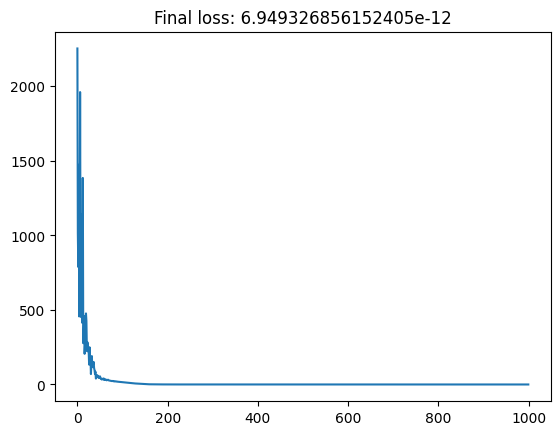

In [3]:
g = torch.Generator().manual_seed(12345)
losses = []
for i in range(epochs):
    blosses = []
    for b in range(num_batches):
        ix = torch.randint(0, X.shape[0], (batch_size, ), generator=g)
        X_batch, y_batch = X[ix], y[ix]
        X_batch, y_batch = torch.Tensor(X_batch).to(device), torch.Tensor(y_batch).to(device)
        y_pred = model(X_batch)
        loss = mse(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        blosses.append(loss.item())
        assert np.isfinite(blosses[-1]), f"NaN at epoch {i}, batch {b}"
    losses.append(np.mean(blosses))

plt.plot(np.arange(len(losses)), losses)
plt.title(f"Final loss: {losses[-1]}")
plt.show();


In [5]:
print("Original lambdas:\t", pt.lambdas_)
print("Model lambdas   :\t", model.lambdas.detach().cpu().numpy())

Original lambdas:	 [ 0.43504319 -0.79943349 -0.40310897 -2.26706388  0.02686084  4.82924734
  0.36561979]
Model lambdas   :	 [ 0.43504152 -0.7994335  -0.40310845 -2.267053    0.02686075  4.8292437
  0.36561975]
